In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score

In [2]:
def get_datasets(std_size=False):
    # My python only likes absolute paths 
    brca = pd.read_csv('/Users/danielraad/Desktop/data/Gistic2_CopyNumber_BRCA', sep='\t')
    ovca = pd.read_csv('/Users/danielraad/Desktop/data/Gistic2_CopyNumber_OVCA', sep='\t')
    brca.set_index('Gene Symbol', inplace=True)
    ovca.set_index('Gene Symbol', inplace=True)
    brca = brca.transpose()
    ovca = ovca.transpose()
    brca['BRCA'] = 1
    ovca['BRCA'] = 0
    print('size brca, ovca', len(brca), len(ovca))
    if not std_size:
        print('normal size', len(brca)+len(ovca))
        df = pd.concat([brca, ovca[1:]])
    elif std_size:
        print('sampled size', len(ovca)+len(ovca))
        df = pd.concat([brca[0:len(ovca)], ovca[1:]])
    return df
df = get_datasets()

size brca, ovca 1080 579
normal size 1659


/Users/danielraad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [3]:
#seperate the target variable from the other variables
from sklearn.model_selection import train_test_split
y = df["BRCA"]
X = df[df.columns[:-1]]
X_train, X_test, y_train, y_tests = train_test_split(X, y, test_size = 0.33)
y_red = pd.Series(y)
features = list(X_train.columns)

In [10]:
#seperate the target variable from the other variables
from sklearn.model_selection import train_test_split
X, y = df.drop(['BRCA'], axis = 1), df['BRCA']
X_train, X_test, y_train, y_tests = train_test_split(X, y, test_size = 0.33)
y_red = pd.Series(y)
features = list(X_train.columns)

In [12]:
#Random forest classifier model 
from sklearn.ensemble import RandomForestClassifier 
model = RandomForestClassifier(random_state = 42)
model.fit(X_train, y_train)



/Users/danielraad/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [13]:
#Depths of the decision trees 
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 97
Average maximum depth 15


In [48]:
## Evaluation methods adapted from:
# https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/Random%20Forest%20Tutorial.ipynb

In [14]:
## Evaluation
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [15]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_tests, [1 for _ in range(len(y_tests))])
    baseline['precision'] = precision_score(y_tests, [1 for _ in range(len(y_tests))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_tests, predictions)
    results['precision'] = precision_score(y_tests, predictions)
    results['roc'] = roc_auc_score(y_tests, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_tests, [1 for _ in range(len(y_tests))])
    model_fpr, model_tpr, _ = roc_curve(y_tests, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [16]:
#The most important features 
fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

,feature,importance
97,ABHD15,0.045714
21417,TIMM13,0.043389
18420,SCARNA20|ENSG00000251818.1,0.040420
22866,UNC119,0.036979
632,AMH,0.034165
5069,EBI3,0.033721
24230,ZNRF4,0.031988
2915,CCT6B,0.031720
17599,RNA5SP438,0.029827
15328,PSMD3,0.029080


In [17]:
#results from the model 
train_rf_predictions = model.predict(X_train)
train_rf_probs       = model.predict_proba(X_train)[:, 1]

rf_predictions = model.predict(X_test)
rf_probs       = model.predict_proba(X_test)[:, 1]


Recall Baseline: 1.0 Test: 0.93 Train: 1.0
Precision Baseline: 0.64 Test: 0.96 Train: 1.0
Roc Baseline: 0.5 Test: 0.97 Train: 1.0


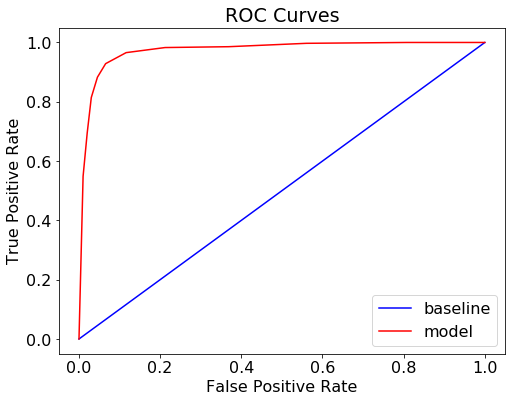

In [18]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)


Confusion matrix, without normalization
[[185  13]
 [ 25 325]]


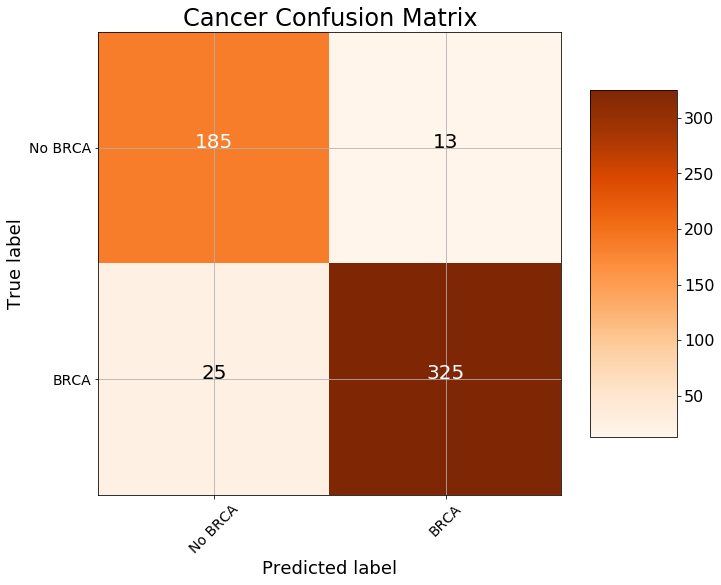

In [19]:
cm = confusion_matrix(y_tests, rf_predictions)
plot_confusion_matrix(cm, classes = ['No BRCA', 'BRCA'],
                      title = 'Cancer Confusion Matrix')

In [21]:
#Scoring with kfold
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model,df,y_red,cv=10,scoring='accuracy')
print(scores.mean())

0.9215954728002922
